# Using submodels in PyBaMM
In this notebook we show how to modify existing models by swapping out submodels, and how to build your own model from scratch using exisitng submodels. To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

## Changing a submodel in an exisiting battery model
PyBaMM is designed to be a flexible modelling package that allows users to easily compare different models and numerical techniques within a common framework. Battery models within PyBaMM are built up using a number of submodels that describe different physics included within the model, such as mass conservation in the electrolyte or charge conservation in the solid. For ease of use, a number of popular battery models are pre-configured in PyBaMM. As an example, we look at the Single Particle Model (for more information see [here](./models/SPM.ipynb)). First we import PyBaMM and any other packages we need

In [1]:
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an exisitng battery model you need to load it without building it by passing the keyword `build=False`

In [2]:
model = pybamm.lithium_ion.SPM(build=False)

This collects all of the submodels which make up the SPM, but doesn't build the model. Now you are free to swap out one submodel for another. For instance, you may want to assume that diffusion within the negative particles is infinitely fast, so that the PDE describing diffusion is replaced with an ODE for the uniform particle concentration. To change a submodel you simply update the dictionary entry

In [3]:
model.submodels["negative particle"] = pybamm.particle.FickianSingleParticle(model.param, "Negative")
model.submodels["positive particle"] = pybamm.particle.FickianSingleParticle(model.param, "Positive")
model.submodels["particle cracking"] = pybamm.particle_cracking.CrackPropagation(model.param, "Negative")

Building the model also sets up the equations, boundary and initial conditions for the model.

In [4]:
model.build_model()

We can get the default parameters for the model and update them with the parameters required by the cracking model. Eventually, we would like these to be added to their won chemistry (you might need to adjust the path to the parameters file to your system).

In [5]:
param = model.default_parameter_values

import pandas as pd
mechanics = pd.read_csv("pybamm/input/parameters/lithium-ion/mechanicals/lico2_graphite_Ai2020/parameters.csv", 
                        index_col=0, comment="#", skip_blank_lines=True, header=None)[1][1:].dropna().astype(float).to_dict()
param.update(mechanics, check_already_exists=False)

Now the model can be processed and solved in the usual way, and we still have access to model defaults such as the default geometry and default spatial methods

In [16]:
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
t_eval = np.linspace(0, 3600, 100)
solution = model.default_solver.solve(model, t_eval)

DomainError: Domain cannot be the same as an auxiliary domain

[[4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]
 [4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]
 [4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]
 ...
 [4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]
 [4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]
 [4.09450845e-18 5.53740217e-04 7.13460239e-04 ... 1.04477166e-03
  1.04477166e-03 1.04477166e-03]]


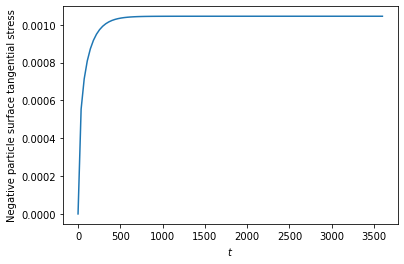

[0.         0.00160911 0.00321822 0.00482733 0.00643644 0.00804555
 0.00965466 0.01126377 0.01287288 0.01448199 0.01609109 0.0177002
 0.01930931 0.02091842 0.02252753 0.02413664 0.02574575 0.02735486
 0.02896397 0.03057308 0.03218219 0.0337913  0.03540041 0.03700952
 0.03861863 0.04022774 0.04183685 0.04344596 0.04505507 0.04666417
 0.04827328 0.04988239 0.0514915  0.05310061 0.05470972 0.05631883
 0.05792794 0.05953705 0.06114616 0.06275527 0.06436438 0.06597349
 0.0675826  0.06919171 0.07080082 0.07240993 0.07401904 0.07562815
 0.07723725 0.07884636 0.08045547 0.08206458 0.08367369 0.0852828
 0.08689191 0.08850102 0.09011013 0.09171924 0.09332835 0.09493746
 0.09654657 0.09815568 0.09976479 0.1013739  0.10298301 0.10459212
 0.10620123 0.10781033 0.10941944 0.11102855 0.11263766 0.11424677
 0.11585588 0.11746499 0.1190741  0.12068321 0.12229232 0.12390143
 0.12551054 0.12711965 0.12872876 0.13033787 0.13194698 0.13355609
 0.1351652  0.13677431 0.13838341 0.13999252 0.14160163 0.143210

In [15]:
# extract voltage
stress_t_n_surf = solution['Negative particle surface tangential stress']
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
print(stress_t_n_surf.entries)
# plot
plt.plot(t, stress_t_n_surf(t=t,x=x[0]))
plt.xlabel(r'$t$')
plt.ylabel('Negative particle surface tangential stress')
plt.show()